In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report


In [2]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
# Define image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 40

# Define train and validation directories
train_dir = '/content/drive/MyDrive/AML/train'
val_dir = '/content/drive/MyDrive/AML/val'

# Define data generator with data augmentation for train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Define data generator without data augmentation for validation set
val_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of images for train and validation sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [4]:
# Load pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_width, img_height, 3)))

58889256/58889256 [==============================] - 0s 0us/step


In [5]:
# Freeze pre-trained layers
for layer in vgg16.layers:
    layer.trainable = False


In [6]:
# Add new classifier
x = Flatten()(vgg16.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Create new model with pre-trained layers and new classifier
model = Model(inputs=vgg16.input, outputs=x)


In [11]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [13]:
# Train the model
epochs = 10
# Fit the model to the training data
model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n//batch_size)

# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(val_generator, steps=val_generator.n//batch_size)
print("Validation accuracy:", val_acc)

Epoch 1/10
4/4 [==============================] - 8s 574ms/step - loss: 0.3648 - accuracy: 0.8562 - val_loss: 0.3972 - val_accuracy: 0.8500
Epoch 2/10
4/4 [==============================] - 2s 564ms/step - loss: 0.3216 - accuracy: 0.9187 - val_loss: 0.3650 - val_accuracy: 0.8500
Epoch 3/10
4/4 [==============================] - 2s 575ms/step - loss: 0.2894 - accuracy: 0.9312 - val_loss: 0.3397 - val_accuracy: 0.8750
Epoch 4/10
4/4 [==============================] - 2s 568ms/step - loss: 0.2400 - accuracy: 0.9625 - val_loss: 0.3152 - val_accuracy: 0.8750
Epoch 5/10
4/4 [==============================] - 3s 657ms/step - loss: 0.2150 - accuracy: 0.9563 - val_loss: 0.2911 - val_accuracy: 0.8750
Epoch 6/10
4/4 [==============================] - 2s 543ms/step - loss: 0.1852 - accuracy: 0.9688 - val_loss: 0.2731 - val_accuracy: 0.9250
Epoch 7/10
4/4 [==============================] - 2s 572ms/step - loss: 0.1697 - accuracy: 0.9500 - val_loss: 0.2570 - val_accuracy: 0.9250
Epoch 8/10
4/4 [====

In [16]:
# Make predictions on the validation data
val_preds = model.predict(val_generator, steps=val_generator.n//batch_size)

# Convert probabilities to class labels
val_preds = (val_preds > 0.5).astype(int)

# Print classification report
class_names = ['chicken', 'duck']
print(classification_report(val_generator.classes, val_preds, target_names=class_names))

1/1 [==============================] - 0s 128ms/step
              precision    recall  f1-score   support

     chicken       0.57      0.65      0.60        20
        duck       0.59      0.50      0.54        20

    accuracy                           0.57        40
   macro avg       0.58      0.57      0.57        40
weighted avg       0.58      0.57      0.57        40



2/2 [==============================] - 0s 152ms/step


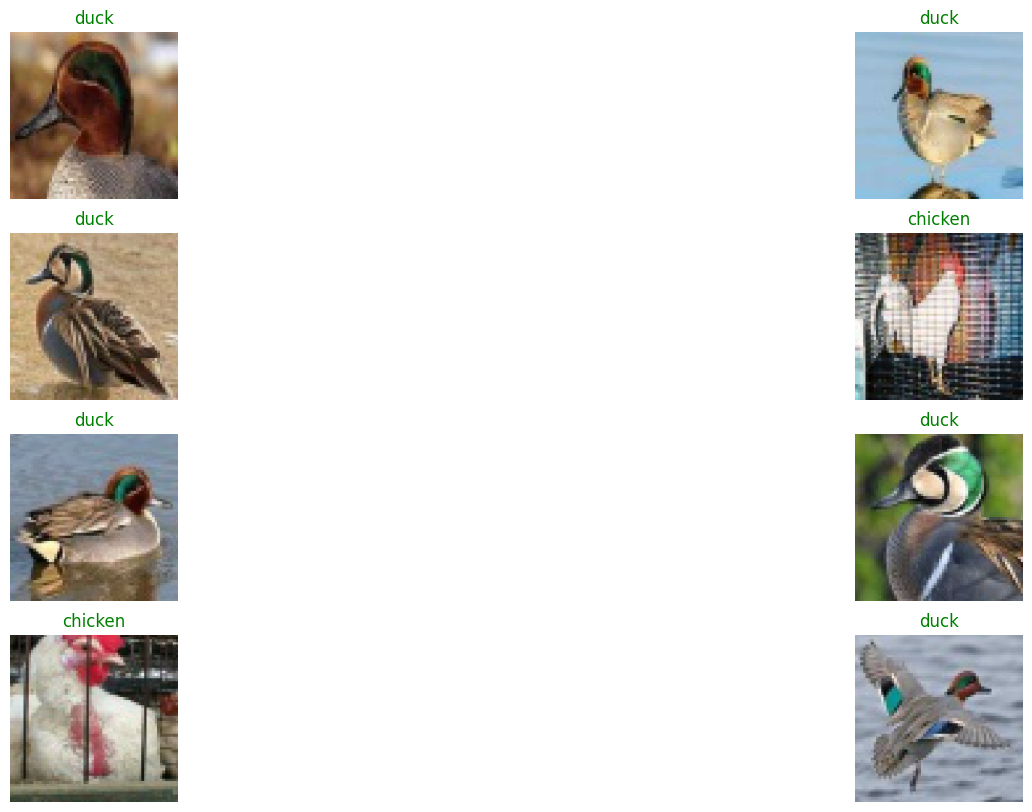

In [17]:
# Get a batch of validation images and labels
val_images, val_labels = next(val_generator)

# Make predictions on the validation images
val_preds = model.predict(val_images)

# Convert probabilities to class labels
val_preds = (val_preds > 0.5).astype(int)

# Print the sample validation
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(4, 2, figsize=(20, 10))
axs = axs.flatten()

for i in range(8):
    # Display the image
    axs[i].imshow(val_images[i])
    axs[i].axis('off')
    
    # Set the title
    if val_preds.flatten()[i] == val_labels[i]:
        axs[i].set_title(class_names[val_preds.flatten()[i]], color='green')
    else:
        axs[i].set_title(class_names[val_preds.flatten()[i]], color='red')

plt.show()
